In [1]:
using Pkg
Pkg.Registry.add(RegistrySpec(url="https://github.com/tensor4all/T4ARegistry.git"))
Pkg.activate(".")
Pkg.instantiate()

     Cloning registry from "https://github.com/tensor4all/T4ARegistry.git"
Registry `Tensor4All` already exists in `~/.julia/registries/Tensor4All`.
  Activating project at `~/project/2025/FluidDynamics/T4AAdaptivePatchedTCI.jl/notebooks`


In [2]:
using Revise
using Random
import QuanticsGrids as QG

# Make sure to load T4AITensorCompat first
# before importing other T4A packages
# to activate the ITensor-related extension
import ITensors: ITensors, Index
import T4AITensorCompat as T4AIT
import T4ATensorCI as TCI
import T4ATensorCI
import T4AQuanticsTCI as QTCI
import T4APartitionedTT as T4AP
import T4APartitionedTT: PartitionedTT, SubDomainTT, adaptive_patching, Projector
import T4AAdaptivePatchedTCI as PatchedTCI
using CairoMakie
using Test

[ Info: Precompiling IJuliaReviseExt [b74c6c38-2542-566b-9b5f-490bff998244] (cache misses: wrong dep version loaded (2))

SYSTEM: caught exception of type :MethodError while trying to print a failed Task notice; giving up


In [3]:
Random.seed!(1234)

gaussian(x, y) = exp(- ((x-5)^2 + (y-5)^2)) + exp(- ((x+5)^2 + (y+5)^2))

R = 20
xmax = 10.0
grid = QG.DiscretizedGrid{2}(R, (-xmax, -xmax), (xmax, xmax); unfoldingscheme=:interleaved)
localdims = fill(2, 2R)  # interleaved: 2R sites (R for x, R for y)

# Convert gaussian function to quantics coordinates
qf = x -> gaussian(QG.quantics_to_origcoord(grid, x)...)

tol = 1e-7
maxbonddim = 30

# Create patch ordering (interleaved: 2R sites)
pordering = PatchedTCI.PatchOrdering(collect(1:2R))

# Create TCI2PatchCreator
creator = PatchedTCI.TCI2PatchCreator(
    Float64,
    PatchedTCI.makeprojectable(Float64, qf, localdims),
    localdims,
    maxbonddim=maxbonddim,
    tolerance=tol,
    verbosity=1,
    ntry=10,
)

# Run adaptive interpolation
results = PatchedTCI.adaptiveinterpolate(creator, pordering; verbosity=1)
patched_tt = PatchedTCI.ProjTTContainer(results)

Processing 1 tasks...
Found 5 global pivots
Found 2 global pivots
Found 1 global pivots
Found 0 global pivots
Processing 2 tasks...
Found 5 global pivots
Found 2 global pivots
Found 1 global pivots
Found 1 global pivots
Found 5 global pivots
Found 1 global pivots
Found 1 global pivots
Found 1 global pivots
Processing 4 tasks...
Found 0 global pivots
Found 0 global pivots
Found 0 global pivots
Found 5 global pivots
Found 5 global pivots
Found 4 global pivots
Found 5 global pivots
Found 0 global pivots
Found 0 global pivots
Found 0 global pivots
Found 5 global pivots
Found 5 global pivots
Found 4 global pivots
Found 2 global pivots
Processing 4 tasks...
Found 5 global pivots
Found 3 global pivots
Found 0 global pivots
Found 0 global pivots
Found 0 global pivots
Found 5 global pivots
Found 2 global pivots
Found 0 global pivots
Found 0 global pivots
Found 0 global pivots
Found 0 global pivots
Found 5 global pivots
Found 4 global pivots
Found 0 global pivots
Found 0 global pivots
Found 0 gl

(::T4AAdaptivePatchedTCI.ProjContainer{Float64, T4AAdaptivePatchedTCI.ProjTensorTrain{Float64}}) (generic function with 5 methods)

In [4]:
@show patched_tt

patched_tt = ProjTTContainer{Float64} with 7 patches, max bond dimension: 29


(::T4AAdaptivePatchedTCI.ProjContainer{Float64, T4AAdaptivePatchedTCI.ProjTensorTrain{Float64}}) (generic function with 5 methods)

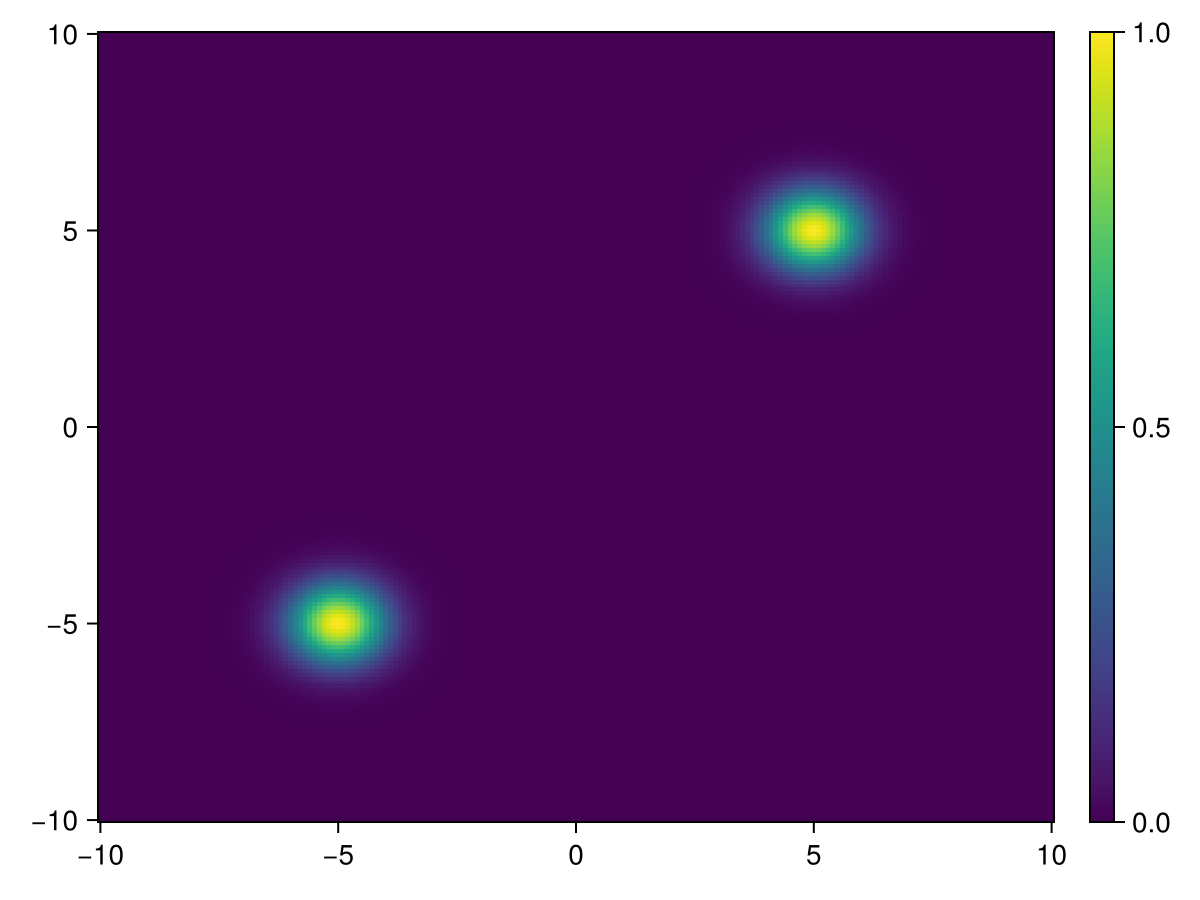

In [5]:
#heatmap(-xmax:0.1:xmax, -xmax:0.1:xmax, gaussian)
fig = Figure()
ax = Axis(fig[1, 1])
hm = heatmap!(ax, -xmax:0.1:xmax, -xmax:0.1:xmax, gaussian)
Colorbar(fig[1, 2], hm)
fig

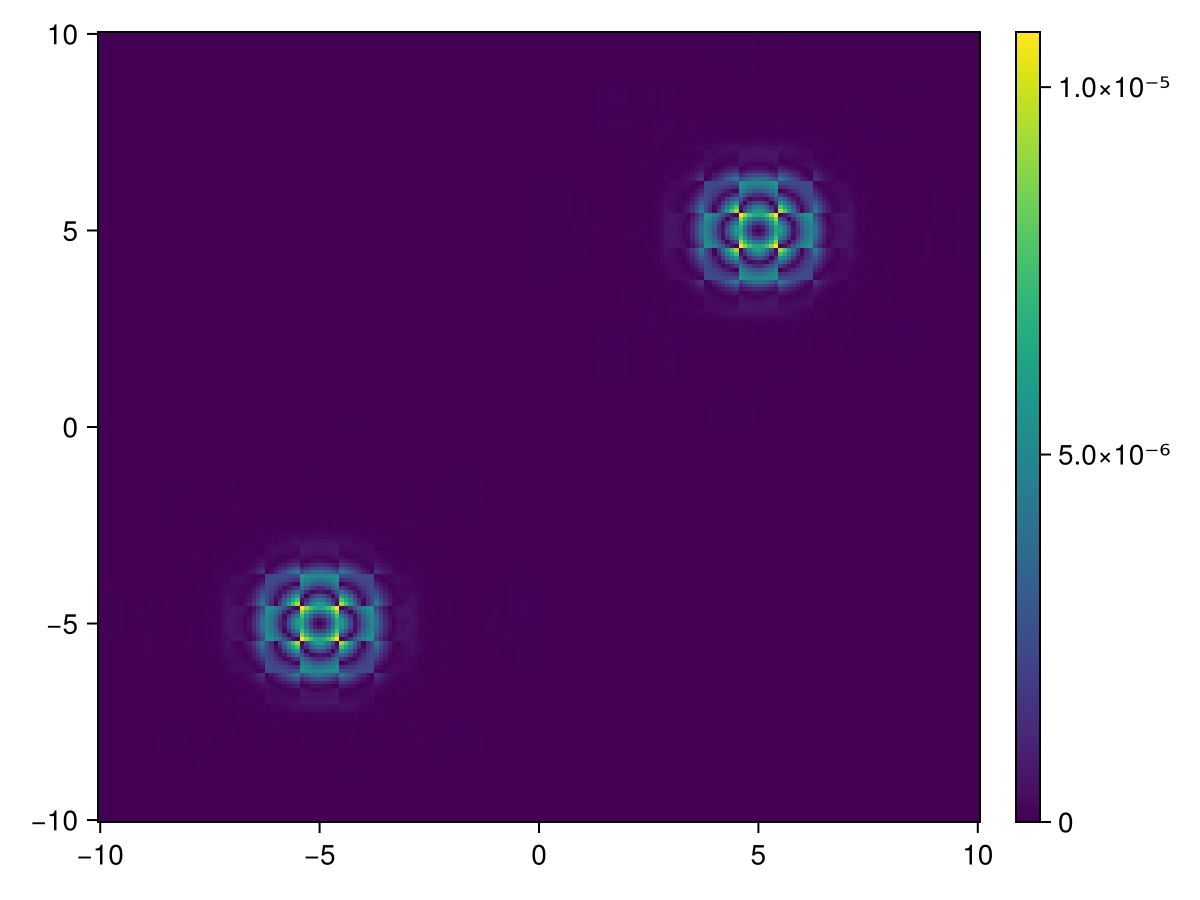

In [6]:
_to_nested(x) = [[x_] for x_ in x]
_err(x...) = abs(patched_tt(_to_nested(QG.origcoord_to_quantics(grid, x))) - gaussian(x...))
fig = Figure()
ax = Axis(fig[1, 1])
hm = heatmap!(ax, -xmax:0.1:xmax, -xmax:0.1:xmax, _err)
Colorbar(fig[1, 2], hm)
fig

In [7]:
function bound_idx(p::PatchedTCI.Projector, grid1d, sitedims)::Tuple{Float64,Float64}
    # p.data is Vector{Vector{Int}}, where p.data[isite][ilegg] is the projection value
    # 0 means no projection, >0 means projected to that value
    # sitedims is Vector{Vector{Int}} corresponding to p.sitedims
    
    # Create lower and upper bound MultiIndex
    # Lower bound: unprojected indices = 1, projected indices = projector value
    # Upper bound: unprojected indices = max value, projected indices = projector value
    lower_idx = TCI.MultiIndex(undef, sum(length.(sitedims)))
    upper_idx = TCI.MultiIndex(undef, sum(length.(sitedims)))
    
    idx_pos = 1
    for (isite, site_dim) in enumerate(sitedims)
        for (ilegg, dim) in enumerate(site_dim)
            proj_val = p.data[isite][ilegg]
            if proj_val == 0
                # Not projected: use full range
                lower_idx[idx_pos] = 1
                upper_idx[idx_pos] = dim
            else
                # Projected: use the projection value
                lower_idx[idx_pos] = proj_val
                upper_idx[idx_pos] = proj_val
            end
            idx_pos += 1
        end
    end
    
    # Convert quantics indices to original coordinates
    lower_coord = QG.quantics_to_origcoord(grid1d, lower_idx)[1]
    upper_coord = QG.quantics_to_origcoord(grid1d, upper_idx)[1]
    
    return (lower_coord, upper_coord)
end

function patch_bound(p::PatchedTCI.Projector, xmin, xmax, ymin, ymax, R)::NTuple{4, Float64}
    xgrid = QG.DiscretizedGrid{1}(R, xmin, xmax)
    ygrid = QG.DiscretizedGrid{1}(R, ymin, ymax)

    # For interleaved representation, x and y indices are interleaved
    # Structure: [x_1, y_1, x_2, y_2, ..., x_R, y_R]
    # p.data has 2R sites, where odd indices are x and even indices are y
    # p.sitedims[isite] has the dimensions for each leg at site isite
    
    # Extract x and y projectors
    x_data = Vector{Int}[]
    x_sitedims = Vector{Int}[]
    y_data = Vector{Int}[]
    y_sitedims = Vector{Int}[]
    
    for isite in 1:length(p.data)
        if isodd(isite)
            # x dimension (odd sites: 1, 3, 5, ...)
            push!(x_data, p.data[isite])
            push!(x_sitedims, p.sitedims[isite])
        else
            # y dimension (even sites: 2, 4, 6, ...)
            push!(y_data, p.data[isite])
            push!(y_sitedims, p.sitedims[isite])
        end
    end
    
    x_proj = PatchedTCI.Projector(x_data, x_sitedims)
    y_proj = PatchedTCI.Projector(y_data, y_sitedims)
    
    # Get bounds for x and y
    x_lower, x_upper = bound_idx(x_proj, xgrid, x_sitedims)
    y_lower, y_upper = bound_idx(y_proj, ygrid, y_sitedims)
    
    return (x_lower, x_upper, y_lower, y_upper)
end

patch_bound (generic function with 1 method)

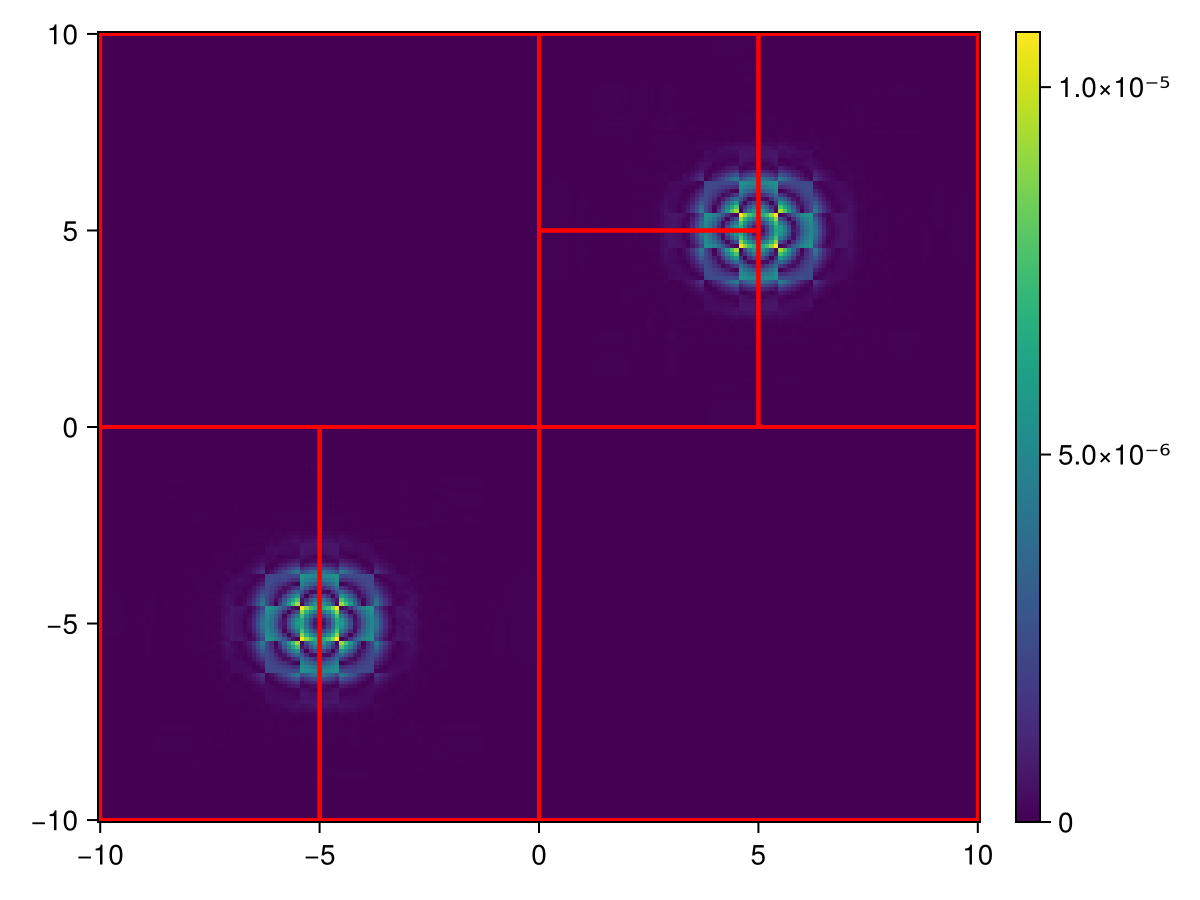

In [8]:
# Function to draw a box with red lines
function draw_box!(ax, x_lower, x_upper, y_lower, y_upper; color=:red, linewidth=2)
    # Create a closed rectangle: [x1, x2, x2, x1, x1] and [y1, y1, y2, y2, y1]
    x_box = [x_lower, x_upper, x_upper, x_lower, x_lower]
    y_box = [y_lower, y_lower, y_upper, y_upper, y_lower]
    lines!(ax, x_box, y_box, color=color, linewidth=linewidth)
end

_to_nested(x) = [[x_] for x_ in x]
_err(x...) = abs(patched_tt(_to_nested(QG.origcoord_to_quantics(grid, x))) - gaussian(x...))

fig = Figure()
ax = Axis(fig[1, 1])
hm = heatmap!(ax, -xmax:0.1:xmax, -xmax:0.1:xmax, _err)
Colorbar(fig[1, 2], hm)

# Draw boxes for all patches
# patched_tt is ProjTTContainer, which contains ProjTensorTrain objects
# Each ProjTensorTrain has a projector field
for ptt in patched_tt
    proj = ptt.projector
    x_lower, x_upper, y_lower, y_upper = patch_bound(proj, -xmax, xmax, -xmax, xmax, R)
    draw_box!(ax, x_lower, x_upper, y_lower, y_upper)
end

fig

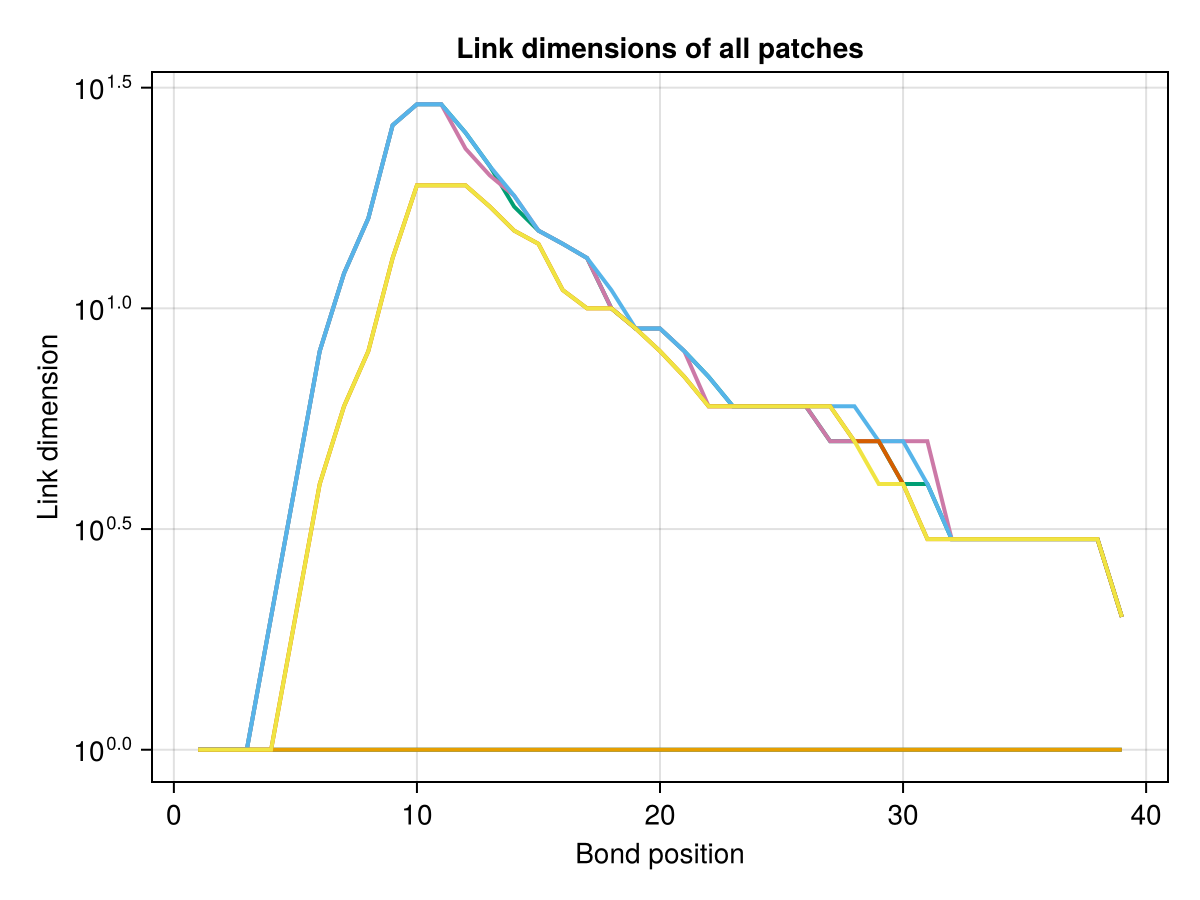

In [9]:
# Plot the linkdims of patches in a single plot
fig = Figure()
ax = Axis(fig[1, 1], xlabel="Bond position", ylabel="Link dimension", title="Link dimensions of all patches", yscale=log10)

# Get linkdims for each patch
# patched_tt is ProjTTContainer, which contains ProjTensorTrain objects
for (patch_idx, ptt) in enumerate(patched_tt)
    # ptt is ProjTensorTrain, which has a data field (TensorTrain{T,3})
    tt = ptt.data
    # linkdims returns bond dimensions between tensors (length = length(tt) - 1)
    linkdims_vec = TCI.linkdims(tt)
    
    # Plot linkdims for this patch
    # Bond positions: 1 to length(linkdims_vec) (between sites 1-2, 2-3, ..., N-1-N)
    bond_positions = 1:length(linkdims_vec)
    lines!(ax, bond_positions, linkdims_vec, label="Patch $patch_idx", linewidth=2)
end

#axislegend(ax, position=:rt)
fig